Damage Propagation Modeling
Aircraft Engine Run-to-Failure Simulation

C-MAPSS is a tool for simulating a realistic large commercial turbofan engine. The software is coded in the MATLAB® and Simulink® environment, and includes a number of editable input parameters that allow the user to enter specific values of his/her own choice regarding operational profile, closed-loop controllers, environmental conditions, etc

Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# define filepath to read data
dir_path = 'archive/'

# define column names for easy indexing
index_names = ['engine_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,engine_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
train[index_names].describe()
train[index_names].groupby('engine_id').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


When inspecting the min time_cycles you can see the engine which failed the earliest did so after 128 cycles, whereas the engine which operated the longest broke down after 362 cycles. The average engine breaks between 199 and 206 cycles, however the standard deviation of 46 cycles is rather big.

In [5]:
train[index_names].groupby('time_cycles').max().describe()

,engine_id
count,362.000000
mean,96.593923
std,7.151566
min,69.000000
25%,96.000000
50%,100.000000
75%,100.000000
max,100.000000


engine_id start at 1 and end at 100 as expected that means FD001 contain data of one hundred engines.

In [6]:
train[setting_names].describe()

,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


When we inspect the descriptive statistics of settings we can see the dataset has a total of 20631 rows.Looking at the standard deviations of settings 1 and 2, they aren’t completely stable. The fluctuations are so small however, that no other operating conditions can be identified.

In [7]:
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


By looking at the standard deviation it’s clear sensors 1, 10, 18 and 19 do not fluctuate at all, these can be safely discarded as they hold no useful information.

Inspecting the quantiles indicates sensors 5, 6 and 16 have little fluctuation and require further inspection. Sensors 9 and 14 have the highest fluctuation.

Calculating RUL for train because it is not given for the train cycles. Mathematically we can use max_time_cycle — time_cycle to compute our desired RUL.

In [3]:
#Computing RUL

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="engine_id")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine_id', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,engine_id,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


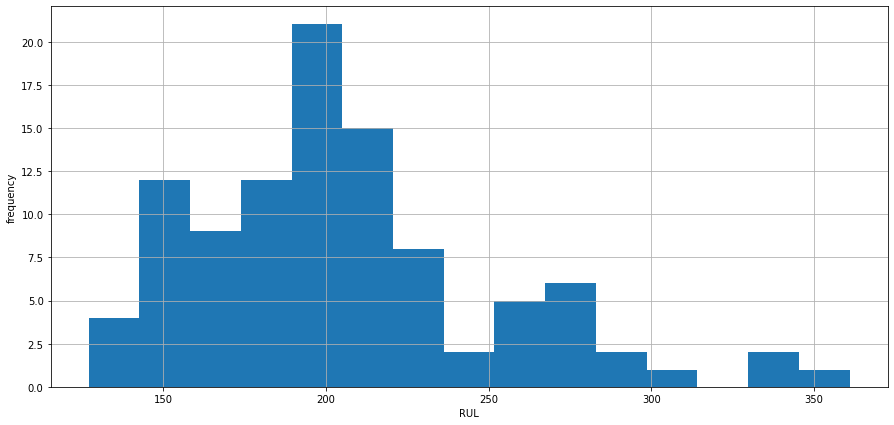

In [9]:
df_max_rul = train[['engine_id', 'RUL']].groupby('engine_id').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

The histogram reconfirms most engines break down around 200 cycles (average engine breaks between 199 and 206 cycles from data description calculated above). Furthermore, the distribution is right skewed, with few engines lasting over 300 cycles.

I chose to plot each engine whose engine_id is divisible by 10 with a remainder of 0 and also revert the X-axis so RUL decreases along the axis, with a RUL of zero indicating engine failure.

In [10]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['engine_id'].unique():
        if (i % 10 == 0):  # only plot every 10th engine_id
            plt.plot('RUL', sensor_name, 
                     data=train[train['engine_id']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

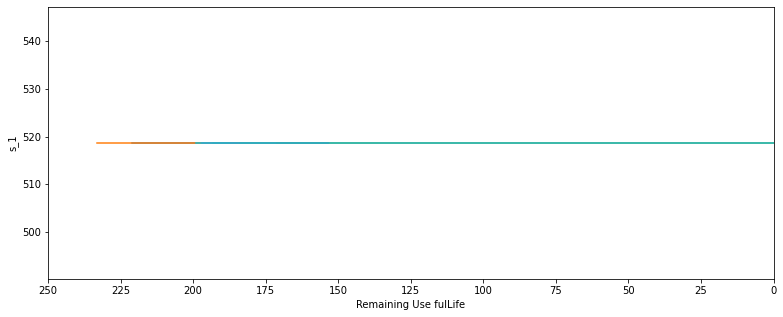

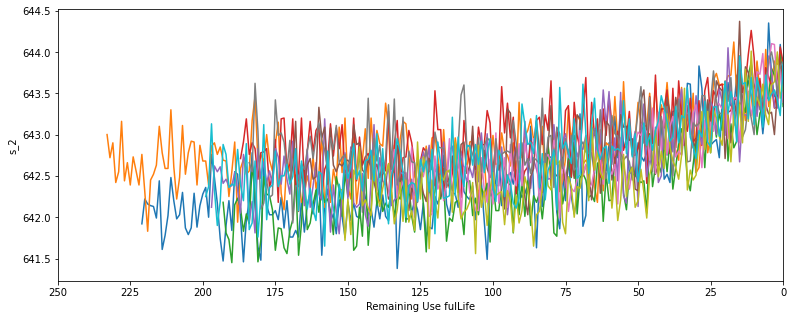

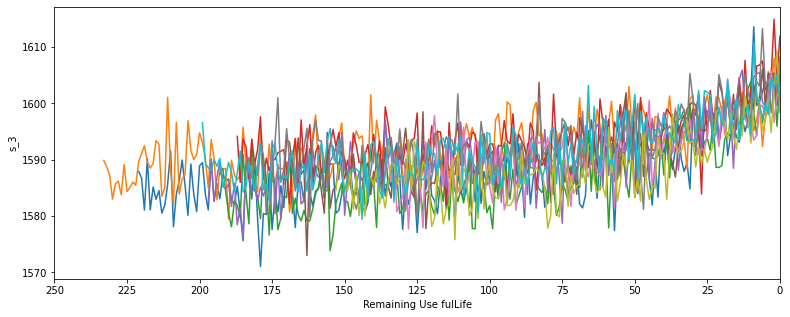

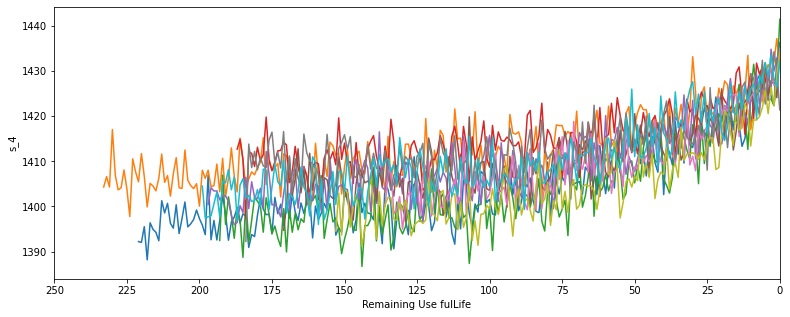

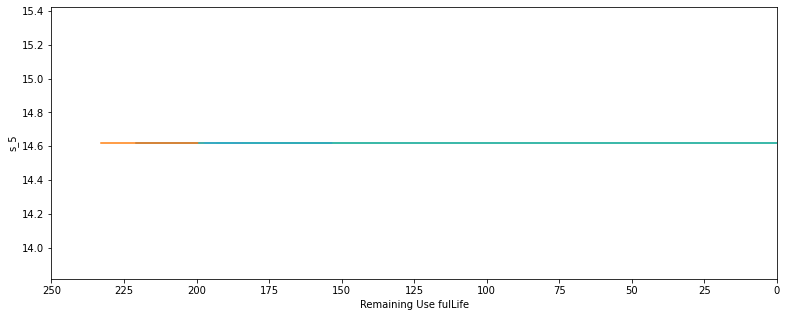

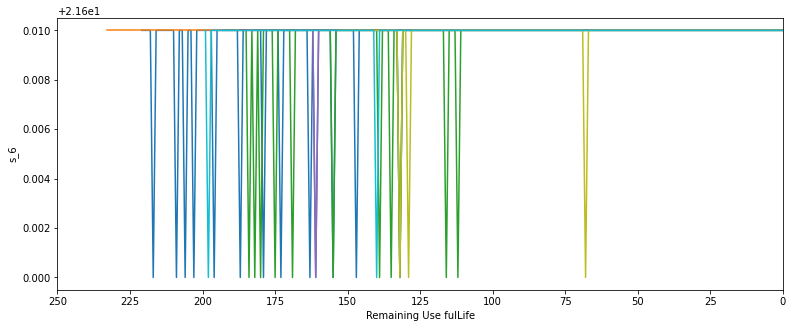

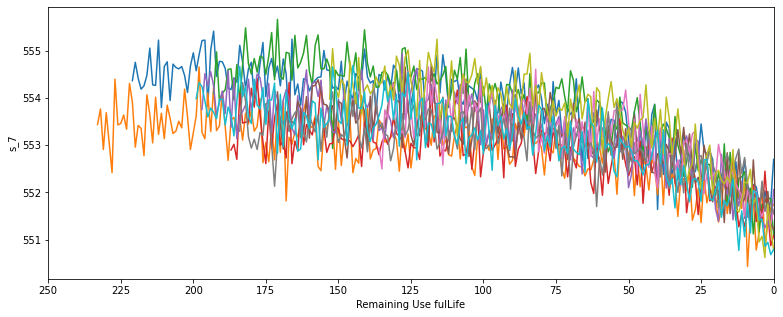

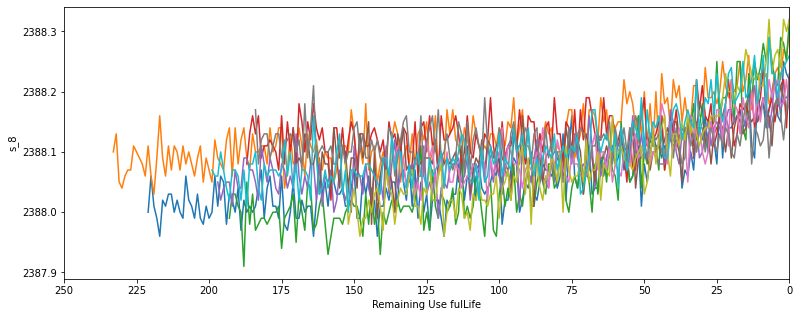

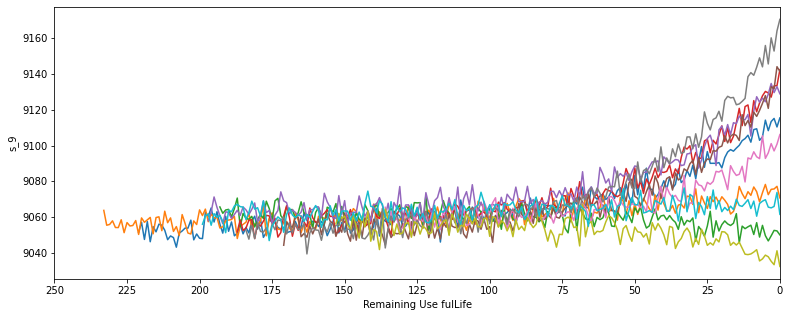

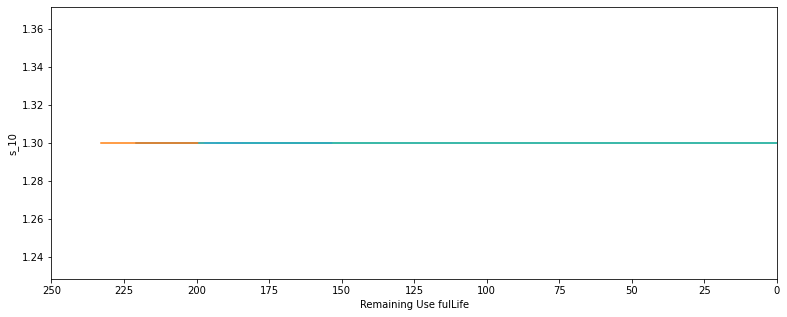

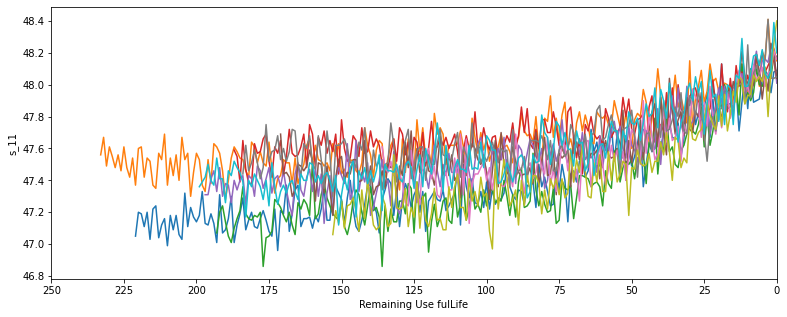

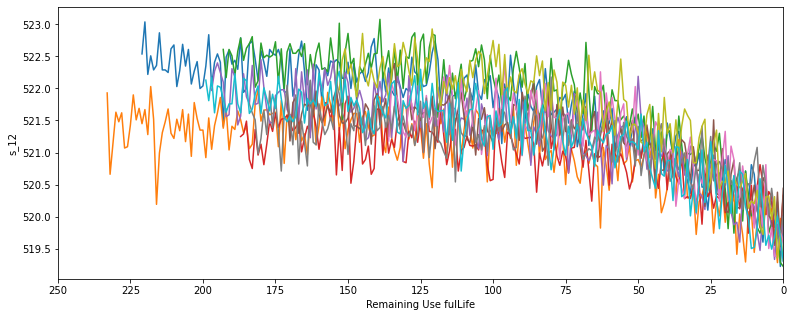

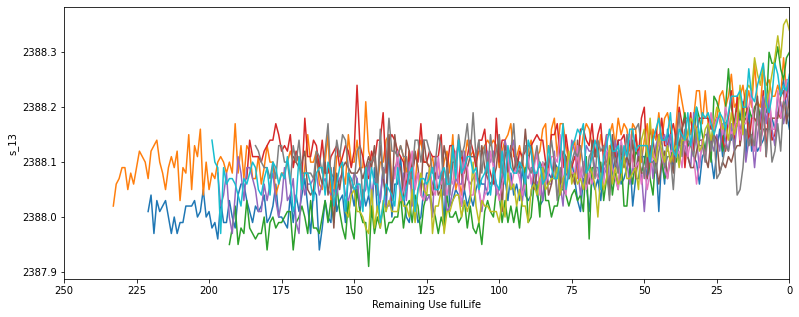

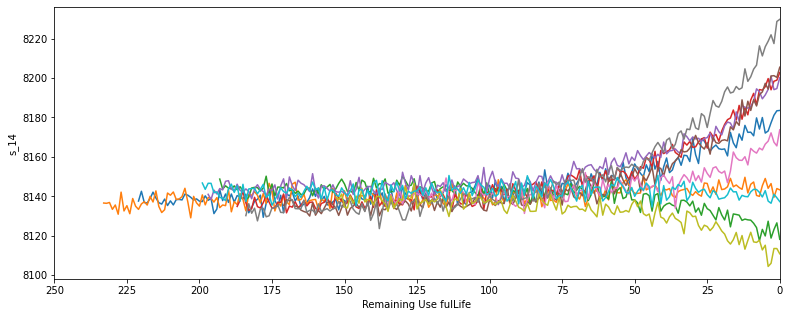

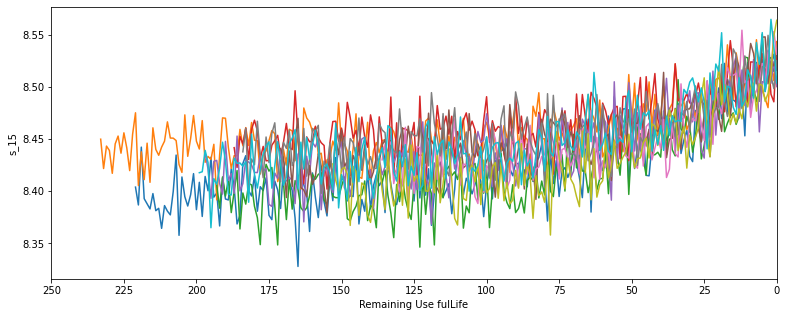

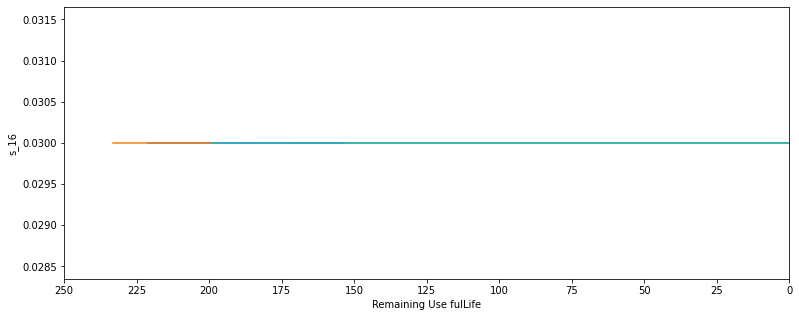

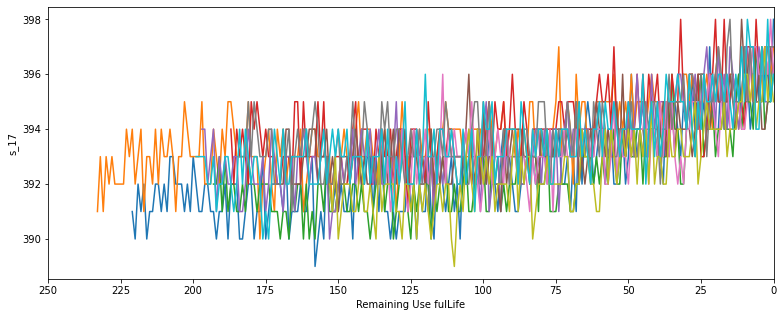

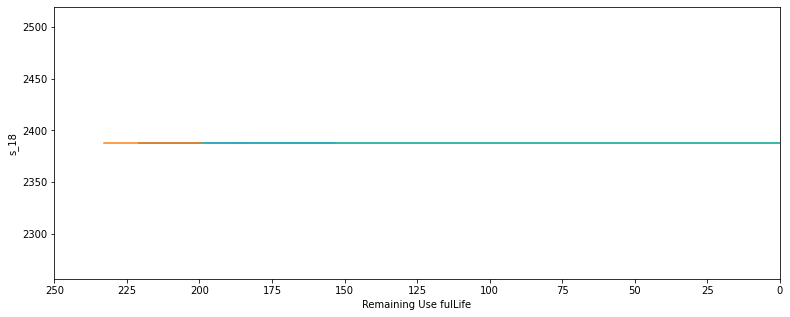

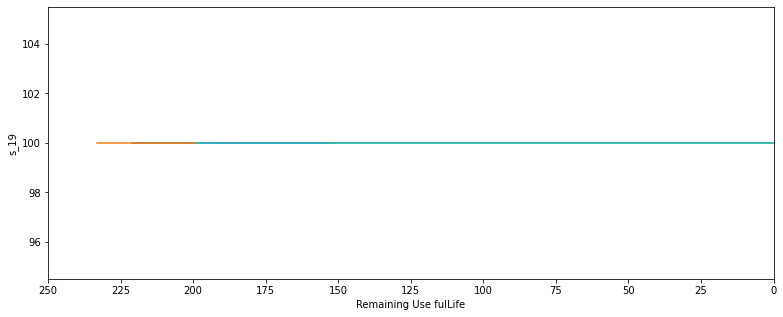

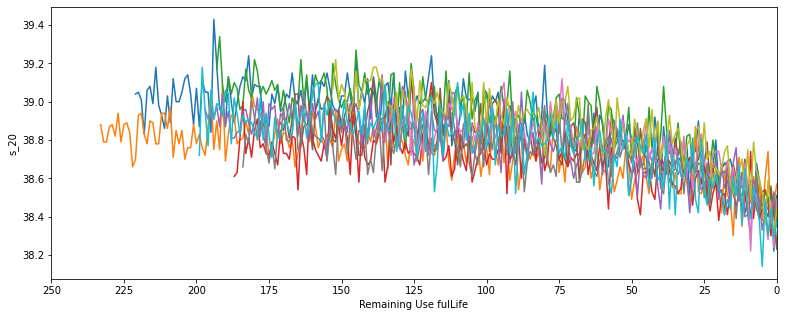

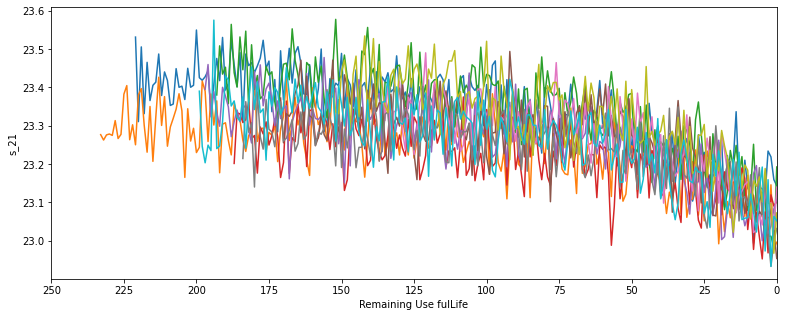

In [11]:
for sensor_name in sensor_names:
    plot_sensor(sensor_name)

The graph of sensors 1, 10, 18 and 19 look similar, the flat line indicates the sensors hold no useful information, which reconfirms our conclusion from the descriptive statistics, i.e. to drop these sensors readings.

However, graph of sensors 5, 16 also show a flat line and our descriptive statistics also shows minimal fluctuations for them as well. These can be added to the list of sensors to exclude. 

Sensor readings of sensor 6 peak downwards at times but there doesn’t seem to be a clear relation to the decreasing RUL.

Sensor 2 shows a rising trend, a similar pattern can be seen for sensors 3, 4, 8, 11, 13, 15 and 17.

Sensor 7 shows a declining trend, which can also be seen in sensors 12, 20 and 21.

Sensor 9 has a similar pattern as sensor 14.

Based on Exploratory Data Analysis we can conclude that sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to RUL as the sensor values remain constant throughout time.

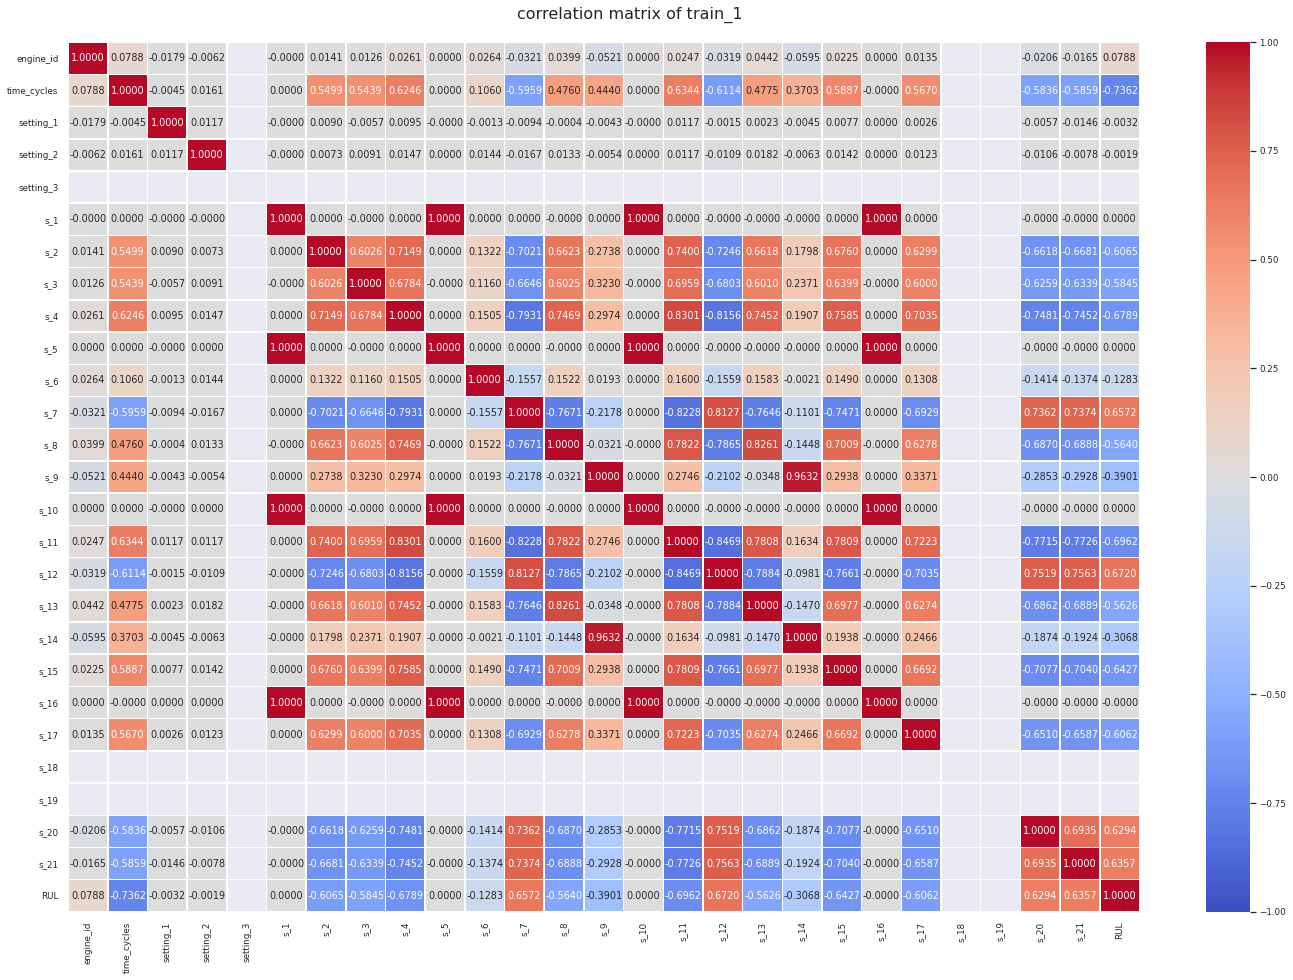

In [12]:
#heatmap for correlation coefficient

# calculate correlation
df_corr = train.corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(24,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("coolwarm", 200))

plt.figtext(.45, 0.9,'correlation matrix of train_1', fontsize=16, ha='center')
plt.xticks(rotation=90)
plt.show()

Untill now we were looking on the sensors values only but after plotting the corelation matrix we came to know that setting_3 can also be dropped as well.

In [4]:
corr_del=["setting_3","s_1", "s_5","s_6","s_10", "s_16", "s_18", "s_19"]
train.drop(columns=corr_del, inplace=True)

['engine_id', 'time_cycles', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']


<AxesSubplot:title={'center':'Feature importance from RandomForest for train set'}, ylabel='None'>

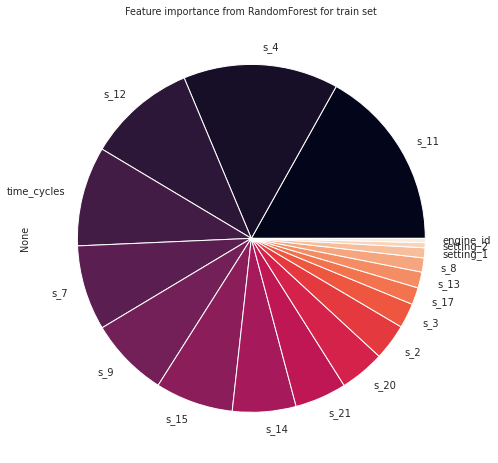

In [14]:
#updating column names for easy indexing
imp_col = ['engine_id', 'time_cycles', 'setting_1', 'setting_2', 's_2', 's_3',
       's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15',
       's_17', 's_20', 's_21']
print(imp_col)
X_imp = train[imp_col]
y_imp = train["RUL"]

#feature importances
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=5)
rf_clf.fit(X_imp, y_imp)

pd.Series(rf_clf.feature_importances_, index = X_imp.columns).nlargest(30).plot(kind = 'pie',
                                                                                figsize = (8, 8),
                                                                                title = 'Feature importance from RandomForest for train set', colormap='rocket', fontsize=10)

Since sensor s_9 and s_14 had the highest fluctuations from statistical description and thier plotted graph against RUL is also the same. From correlation matrix it is evident that s_9 and s_14 are highly co-realted (If they are really similar then one of them needs to go). That's why we carried out feature importance using RF but still the pie slot of s_9 and s_14 appears to be similar. So moving on to Permutation Importance.

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

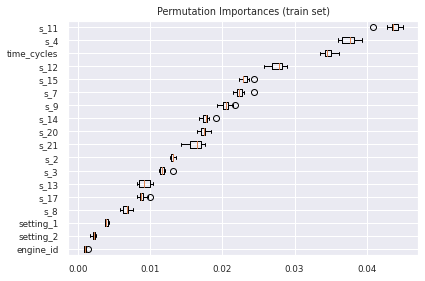

s_11     0.044 +/- 0.001
s_4      0.038 +/- 0.001
time_cycles 0.035 +/- 0.001
s_12     0.028 +/- 0.001
s_15     0.023 +/- 0.001
s_7      0.022 +/- 0.001
s_9      0.020 +/- 0.001
s_14     0.018 +/- 0.001
s_20     0.017 +/- 0.001
s_21     0.016 +/- 0.001
s_2      0.013 +/- 0.000
s_3      0.012 +/- 0.001
s_13     0.009 +/- 0.001
s_17     0.009 +/- 0.001
s_8      0.007 +/- 0.001
setting_1 0.004 +/- 0.000
setting_2 0.002 +/- 0.000
engine_id 0.001 +/- 0.000


In [19]:
atts=train.columns
atts_arr = np.array(atts)
result = permutation_importance(rf_clf, X_imp, y_imp, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=atts_arr[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

for i in result.importances_mean.argsort()[::-1]:
     print(f"{atts_arr[i]:<8} "
           f"{result.importances_mean[i]:.3f}"
           f" +/- {result.importances_std[i]:.3f}")


Since permutation index shows that s_14 is less imporatant than s_9 and they were highly corelated, we will only keep s_9 in our dataset by dropping s_14

In [5]:
#corr matrix results to be deleted 14
corr_del=["s_14"]
train.drop(columns=corr_del, inplace=True)


Now the data is ready by dropping the unimportant parameters. We will normalize it before sending it to the model for learning.

In [13]:
#train minmax scaling
cols_normalize = train.columns.difference(['engine_id','time_cycles'])

print(cols_normalize)

scaler_1 = MinMaxScaler()
norm_rul_train_1 = pd.DataFrame(scaler_1.fit_transform(train[cols_normalize]), 
                                columns=cols_normalize, 
                                index=train.index)

norm_rul_train_1=pd.concat([norm_rul_train_1, train[["engine_id", "time_cycles"]]], axis=1)

Index(['RUL', 's_11', 's_12', 's_13', 's_15', 's_17', 's_2', 's_20', 's_21',
       's_3', 's_4', 's_7', 's_8', 's_9', 'setting_1', 'setting_2'],
      dtype='object')


Up till now since we have removed "setting_3","s_1", "s_5","s_6","s_10", "s_16", "s_18", "s_19", "s_14" from the training dataset same features have to be removed from the test dataset as well.

In [7]:
corr_del=["setting_3","s_1", "s_5","s_6","s_10", "s_16", "s_18", "s_19","s_14"]
test.drop(columns=corr_del, inplace=True)

In [29]:
#computing RUL for testing

updated_index_names = ['s_11', 's_12', 's_13', 's_15', 's_17', 's_2', 's_20', 's_21', 's_3',
       's_4', 's_7', 's_8', 's_9', 'setting_1', 'setting_2']

test = add_remaining_useful_life(test)
test[index_names+['RUL']].head()

,engine_id,time_cycles,RUL
0,1,1,30
1,1,2,29
2,1,3,28
3,1,4,27
4,1,5,26


In [30]:
#test minmax scaling
cols_normalize = test.columns.difference(['engine_id','time_cycles'])

print(cols_normalize)


norm_rul_test_1 = pd.DataFrame(scaler_1.fit_transform(test[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test.index)

norm_rul_test_1=pd.concat([norm_rul_test_1, test[["engine_id", "time_cycles"]]], axis=1)

Index(['RUL', 's_11', 's_12', 's_13', 's_15', 's_17', 's_2', 's_20', 's_21',
       's_3', 's_4', 's_7', 's_8', 's_9', 'setting_1', 'setting_2'],
      dtype='object')


Since we calculated RUL for training dataset we need to calculate it for testing dataset as well.

Now as we saw above that training dataset has values for 100 engines, we must check that testing dataset should also have 100 engines so it would be balanced testing and training data.

In [31]:
#split engines for set_1
g_1=norm_rul_train_1.groupby('engine_id')
g_test1=norm_rul_test_1.groupby('engine_id')

#list of dfs(engines)
train_list = []
test_list = []  

for engineid in g_1.groups.keys():
    train_list.append(g_1.get_group(engineid)) 

for engineid in g_test1.groups.keys():
    test_list.append(g_test1.get_group(engineid))


In [32]:
len(train_list)

100

In [33]:
len(test_list)

100

Confirmed both testing and training dataset have values of 100 engines. Now we will generate sequences for each engine by creating dataset for multivariate one step ahed problem.

In [34]:
#generating sequences for each engine --> multivariate one step problem
from numpy import array

#df: df extracted from train_list, n_steps: window size
def split_sequences(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps
        if end_ix > len(df):
            break
        seq_x, seq_y = df[i:end_ix, 1:], df[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    #print(X)
    return array(X), array(y)


list_x=[]
list_y=[]
for engine_df in train_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "time_cycles"]).to_numpy()
    X, y = split_sequences(engine_arr, 21)#since smallest df has 21 rows
    list_x.append(X)
    list_y.append(y)

#concat alt alta  
X_arr=np.concatenate(list_x)
y_arr=np.concatenate(list_y)

In [35]:
engine_arr.shape #input of split_seq function

(200, 16)

In [28]:
X.shape #output of split_seq function

(180, 21, 15)

In [36]:
y.shape #output of split_seq function

(180,)

In [37]:
X_arr.shape #concat all engines

(18631, 21, 15)

In [38]:
y_arr.shape

(18631,)

Now the data is reshaped and ready for training. Creating Stacked LSTM model for prediction.

In [40]:
seq_len=X_arr.shape[1]
num_features=X_arr.shape[2]

model = Sequential()
model.add(LSTM(input_shape=(seq_len, num_features), units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

#This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
#regularization technique as preventing overfitting, model runtime gets shorter
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 21, 100)           46400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 50)            30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [41]:
# fit model
history=model.fit(X_arr, y_arr, epochs=200, callbacks=[callback])
len(history.history['loss']) 

Epoch 1/200
583/583 [==============================] - 11s 14ms/step - loss: 0.0157
Epoch 2/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0120
Epoch 3/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0111
Epoch 4/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0105
Epoch 5/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0102
Epoch 6/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0102
Epoch 7/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0099
Epoch 8/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0097
Epoch 9/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0096
Epoch 10/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0094
Epoch 11/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0093
Epoch 12/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0094


583/583 [==============================] - 8s 14ms/step - loss: 0.0013
Epoch 99/200
583/583 [==============================] - 10s 17ms/step - loss: 0.0013
Epoch 100/200
583/583 [==============================] - 11s 18ms/step - loss: 0.0013
Epoch 101/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0013
Epoch 102/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0017
Epoch 103/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0012
Epoch 104/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0012
Epoch 105/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0012
Epoch 106/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0012
Epoch 107/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0012
Epoch 108/200
583/583 [==============================] - 10s 18ms/step - loss: 0.0013
Epoch 109/200
583/583 [==============================] - 10s 17ms/step - loss

583/583 [==============================] - 8s 14ms/step - loss: 9.8074e-04
Epoch 194/200
583/583 [==============================] - 8s 14ms/step - loss: 9.8277e-04
Epoch 195/200
583/583 [==============================] - 8s 14ms/step - loss: 0.0010
Epoch 196/200
583/583 [==============================] - 9s 15ms/step - loss: 0.0010
Epoch 197/200
583/583 [==============================] - 11s 18ms/step - loss: 9.5473e-04
Epoch 198/200
583/583 [==============================] - 10s 17ms/step - loss: 9.5730e-04
Epoch 199/200
583/583 [==============================] - 8s 14ms/step - loss: 9.7934e-04
Epoch 200/200
583/583 [==============================] - 8s 14ms/step - loss: 9.4459e-04


200

In [187]:
#prepare test set to make predictions
list_x_test=[]
list_y_test=[]

for engine_df in test_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "time_cycles"]).to_numpy()
    X, y = split_sequences(engine_arr, seq_len)
    
    
    #use only last seq for each engine
    list_x_test.append(X)
    list_y_test.append(y)
#print(y)
#print(y.shape)
#print(list_y_test)
#concat alt alta  
X_arr_test=np.concatenate(list_x_test)
y_arr_test=np.concatenate(list_y_test)
#print(y_arr_test)

In [188]:
X_arr_test.shape

(11096, 21, 15)

In [189]:
y_arr_test.shape

(11096,)

We have to make inverse scaling for RUL column in order to produce proper prediction results

In [113]:
#create a dummy df to take inverse only on one col --> "y_pred"
def invTransform(scaler, y_pred, colNames):
    dummy = pd.DataFrame(np.zeros((len(y_pred), len(colNames))), columns=colNames)
    dummy["RUL"] = y_pred
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy["RUL"].values

In [190]:
#prediction
y_pred = model.predict(X_arr_test, verbose=0)

#inverse scaling for y_pred values
y_pred_inv=invTransform(scaler_1, y_pred, cols_normalize)
#print(y_pred)
y_pred_reshaped=y_pred_inv.reshape((len(y_pred_inv, )))
#y_pred_reshaped=y_pred.reshape((len(y_pred_inv, )))
y_pred_reshaped.shape

(11096,)

In [117]:
y_pred_reshaped

array([105.17456961,  53.83215249,  12.59149811,  19.52418724,
        29.82405111,  33.54258862,  64.36764425,  35.02652231,
        38.85999817,  35.42877278,  19.18424135,  33.19034833,
        31.06445014,  32.43649659,  51.89359108,  60.95482898,
        17.49560031,  12.7437337 ,  75.23164251,   2.07506448,
        35.79497254,  69.92237824, 110.80980229,   6.57470214,
        85.59197491,  49.80400461,  77.86945534,  43.19515532,
        36.55099335,  27.71645954,   1.82461309,  22.48719895,
        35.71673292,   2.02725488,   1.87182868,   2.26950699,
         9.4942919 ,  11.38053006,  74.28282174,   2.53737396,
         7.87650573,   2.5775153 ,  16.48390794,  80.15422684,
        23.22207806,  14.22224471,  30.2598682 ,  63.29878646,
         2.21435314,  50.48247433,  42.70422488,  13.34724891,
         9.29486322,  72.12206089,  42.47541022,   2.26451182,
        28.6321502 ,   9.95216873,  42.80459625,  47.87852514,
         3.90377271,  18.98685575,  28.41242585,   3.46

In [81]:
#error cal. for paper
def score(y_true, y_pred, a1=10, a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [82]:
score(y_truth,y_pred_reshaped)

0.8754776743225001

In [83]:
def score_func(y_true, y_pred):
    score_list = [
                  round(score(y_true,y_pred), 2), 
                  round(mean_absolute_error(y_true,y_pred), 2),
                  round(mean_squared_error(y_true,y_pred),2) ** 0.5,
                  round(r2_score(y_true,y_pred), 2)
                  ]
    
    print(f' R2 score: {score_list[3]}')
    print(f' compatitive score: {score_list[0]}')
    print(f' mean absolute error: {score_list[1]}')
    print(f' root mean squared error: {score_list[2]}')
    
    return 0

In [84]:
score_func(y_truth,y_pred_reshaped)

 R2 score: 0.0
 compatitive score: 0.88
 mean absolute error: 0.11
 root mean squared error: 0.1414213562373095


0

In [131]:
y_pred

array([[0.34826016],
       [0.17825216],
       [0.0416937 ],
       [0.06464963],
       [0.09875514],
       [0.11106817],
       [0.2131379 ],
       [0.11598186],
       [0.12867549],
       [0.11731382],
       [0.06352398],
       [0.10990182],
       [0.10286242],
       [0.10740562],
       [0.17183308],
       [0.20183718],
       [0.05793245],
       [0.04219779],
       [0.2491114 ],
       [0.00687107],
       [0.1185264 ],
       [0.23153105],
       [0.36691988],
       [0.02177054],
       [0.28341714],
       [0.16491392],
       [0.25784588],
       [0.14303032],
       [0.12102978],
       [0.09177636],
       [0.00604177],
       [0.07446092],
       [0.11826733],
       [0.00671276],
       [0.00619811],
       [0.00751492],
       [0.03143805],
       [0.03768387],
       [0.24596961],
       [0.0084019 ],
       [0.02608114],
       [0.00853482],
       [0.05458248],
       [0.26541135],
       [0.0768943 ],
       [0.04709353],
       [0.10019824],
       [0.209

In [152]:
y_truth[0]

0.0

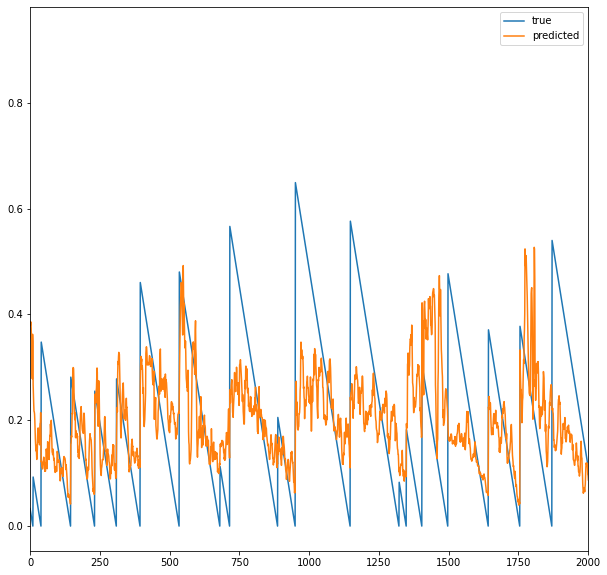

In [193]:
# plot true vs predicted
plt.figure(figsize=(10,10))
plt.plot(y_arr_test, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()
plt.xlim(0, 2000)
plt.show()